## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [76]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=36)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(task, T, its_eq=0, its=0):
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
        return eq_data, eq_facts, atoms_data, energy_data, energy_facts
    
    if task == 3:
        if T:
            filename_corr = f'data/task_{task}/auto_corr_{T}.csv'
            filename_block = f'data/task_{task}/blocking_{T}.csv'

            N, var_U, var_CV, var_P, var_r = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[1, :]
            auto_corr_data = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[3:, :]
            block_data = np.genfromtxt(filename_block, delimiter=',', dtype=np.float64)[1:, :]

            s_corr_U = auto_corr_data[:, 0][np.where(auto_corr_data[:, 1] < np.exp(-2))[0][0]]
            s_corr_CV = auto_corr_data[:, 0][np.where(auto_corr_data[:, 2] < np.exp(-2))[0][0]]
            s_corr_P = auto_corr_data[:, 0][np.where(auto_corr_data[:, 3] < np.exp(-2))[0][0]]
            s_corr_r = auto_corr_data[:, 0][np.where(auto_corr_data[:, 4] < np.exp(-2))[0][0]]

            error_dict = {'U': [s_corr_U, var_U], 'C_V': [s_corr_CV, var_CV], 'P': [s_corr_P, var_P], 'r': [s_corr_r, var_r]}

            return N, auto_corr_data, block_data, error_dict
        else:
            data = np.genfromtxt('data/task_3/data.csv', delimiter=',', dtype=np.float64, skip_header=1)

            return data
    
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    '''Found here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay'''
    from math import factorial 
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.asmatrix([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def plot_task_1(quantity, T_c, save=False):
    data = np.loadtxt('data/task_1/data.csv', delimiter=',')

    T = data[:, 1]
    if quantity == 'U':
        data = data[:, 2] / 2 / 1000
        y_label = '$U(T)$ [keV]'
        fact = 0.005
    elif quantity == 'P':
        data = abs(data[:, 0])
        y_label = '$\\vert P\\vert$'
        fact = 0.1
    elif quantity == 'C':
        data = data[:, 3]
        y_label = '$C_V$ [eV/K]'
        fact = 0.1
    
    fig = plt.figure(figsize=(7, 7))
    plt.plot(T, data, 'k', lw=2.5, label='MFT Simulation')
    plt.axvline(x=T_c, color='tab:orange', linestyle='--', label='$T_c$')
    plt.xlabel('$T$ [K]')
    plt.ylabel(y_label)
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + abs(plt.ylim()[1] * fact))
    plt.grid(linestyle=':', linewidth=1, alpha=0.6)
    plt.legend(loc='upper left', ncol=2)
    plt.tight_layout()

    if save:
        save_fig(fig, f'{quantity}_T', 1)
    plt.show()

def analyzer_task_2(T, its_eq, its, changed=True, plot=False, save=False):
    if its_eq and its is None:
        fig, axs = plt.subplots(2, len(T), figsize=(20, 14))
        colors = ['tab:blue', 'tab:orange', 'tab:green']
        labels = ['\\textbf{{a)}}', '\\textbf{{b)}}', '\\textbf{{c)}}', '\\textbf{{d)}}', '\\textbf{{e)}}', '\\textbf{{f)}}']
        if len(T) == 1:
            axs = np.array([[axs[0]], [axs[1]]])
        for i, t in enumerate(T):
            data, eq_facts, _, _, _ = read_data(2, t, its_eq=its_eq[i])
            axs[0, i].plot(data[:, 0], lw=2, color=colors[i])
            axs[1, i].plot(data[:, 1], lw=2, color=colors[i])
            axs[0, 0].set_ylabel('Accepted steps')
            axs[1, 0].set_ylabel('Potential energy [eV]')
            axs[-1, i].set_xlabel('MC steps')
            axs[0, i].set_title(f'$T = {t}$ K', fontsize=40)
            axs[1, i].set_xticks(np.linspace(0, len(data[:, 0]), 3))
            axs[0, i].text(0.65, 0.2, labels[2*i], transform=axs[0, i].transAxes, fontsize=50)
            axs[1, i].text(0.65, 0.2, labels[2*i + 1], transform=axs[1, i].transAxes, fontsize=50)
            axs[0, i].set_xticks([])
        if save:
            plt.tight_layout()
            save_fig(fig, 'burnin', 2)
    elif its and its_eq:
        _, _, atoms_data, energy_data, energy_facts = read_data(2, T, its_eq=its_eq, its=its)
        accept_diff = np.diff(energy_data[:, 0])
        accept_diff = np.insert(accept_diff, 0, True)
        U_changed = energy_data[:, 1][accept_diff > 0]

        if plot and changed:
            fig, axs = plt.subplots(1, 2, figsize=(9, 6))
            axs[0].plot(energy_data[:, 0])
            axs[1].plot(U_changed)
            axs[0].set_ylabel('Accepted steps')
            axs[1].set_ylabel('Potential energy [eV]')
            axs[0].set_xlabel('MC steps')
            axs[1].set_xlabel('MC steps')
            plt.tight_layout()
            
        elif plot and not changed:
            fig, axs = plt.subplots(1, 2, figsize=(9, 6))
            axs[0].plot(energy_data[:, 0])
            axs[1].plot(energy_data[:, 1])
            axs[0].set_ylabel('Accepted steps')
            axs[1].set_ylabel('Potential energy [eV]')
            axs[0].set_xlabel('MC steps')
            axs[1].set_xlabel('MC steps')
            plt.tight_layout()
        
        return U_changed, energy_facts[1]
    
    plt.show()
    
def plot_task_3(quantity, n_atoms=2000, save=False):
    '''
    Plot data for task 3
    quantity: 'U', 'P'  or 'C'
    '''
    if quantity != 'U' and quantity != 'P' and quantity != 'C_V' and quantity != 'r':
        raise ValueError('Invalid Quantity')
    
    # T, U, C_V, P, r,
    data = read_data(3, None)
    T = data[1:, 0] 

    if quantity == 'U':
        Y = data[1:, 1]
        y_label = '$U(T)$ [eV]'
        legend_loc = 'upper left'
        ylim = [-590,-507]
    
    elif quantity == 'C_V':
        Y = data[1:,2] 
        y_label = '$C_V(T)$ [eV/K]'
        legend_loc = 'upper left'
        ylim = [-0.01,0.375] 

    elif quantity == 'P':
        Y = data[1:,3] 
        Y = np.abs(Y)
        y_label = '$P(T)$ [0]'
        legend_loc = 'upper left'
        ylim = [-0.05,1.23]

    elif quantity == 'r':
        Y = data[1:, 4]
        y_label = '$r(T)$ [0]'
        legend_loc = 'upper left'
        ylim = [0.075,1.2]

    plt.figure()
    plt.plot(T, Y,color = 'tab:blue',alpha=1,linewidth = 2, label = f'Data Points, ${quantity}(T)$', marker='o',markersize=7.5)
    if quantity == 'U':
        plt.plot(T, savitzky_golay(Y, 5, 3), color = 'black',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    elif quantity == 'C':
        plt.plot(T, savitzky_golay(Y, 5, 3), color = 'k',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    else:
        plt.plot(T, savitzky_golay(Y, 25, 9), color = 'k',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    plt.grid(linestyle=':', linewidth=1, alpha=0.6)
    plt.xlabel('$T$ [K]')
    plt.ylabel(y_label)
    plt.ylim(ylim)
    plt.legend(fontsize = 17,loc = legend_loc,ncol = 2)
    if save:
        plt.savefig(f'figs/task_3/{quantity}_T_metro.pdf', bbox_inches='tight')
        plt.tight_layout()
    plt.show()

def save_fig(fig, name, task):
    fig.savefig(f'figs/task_{task}/{name}.pdf', bbox_inches='tight')


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

T_c = 905.1524134809046


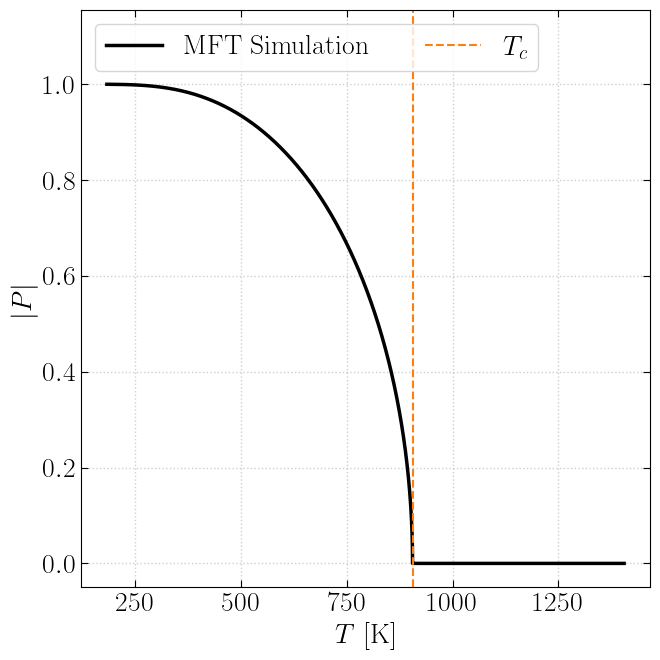

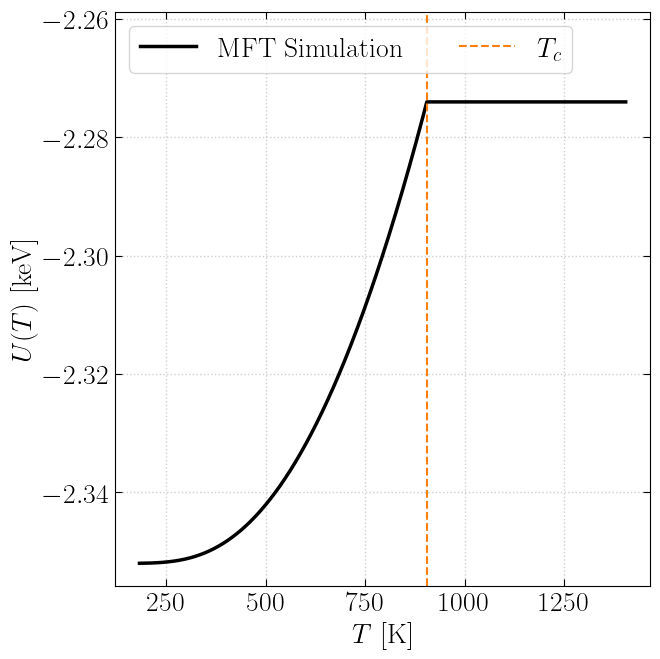

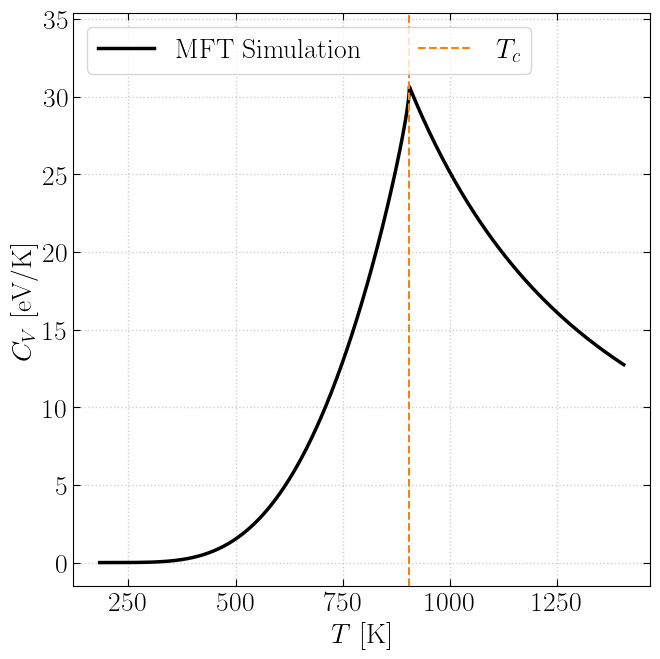

In [ ]:

E_cucu = -0.436
E_znzn = -0.113
E_cuzn = -0.294
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 2*delta_E/k_B
print(f'T_c = {T_c}')

data = np.loadtxt('data/task_1/data.csv', delimiter=',')

plot_task_1('P', T_c, save=False)
plot_task_1('U', T_c, save=False)
plot_task_1('C', T_c, save=False)


### Task 2 - Calculating $U$ using the Metropolis Algorithm 

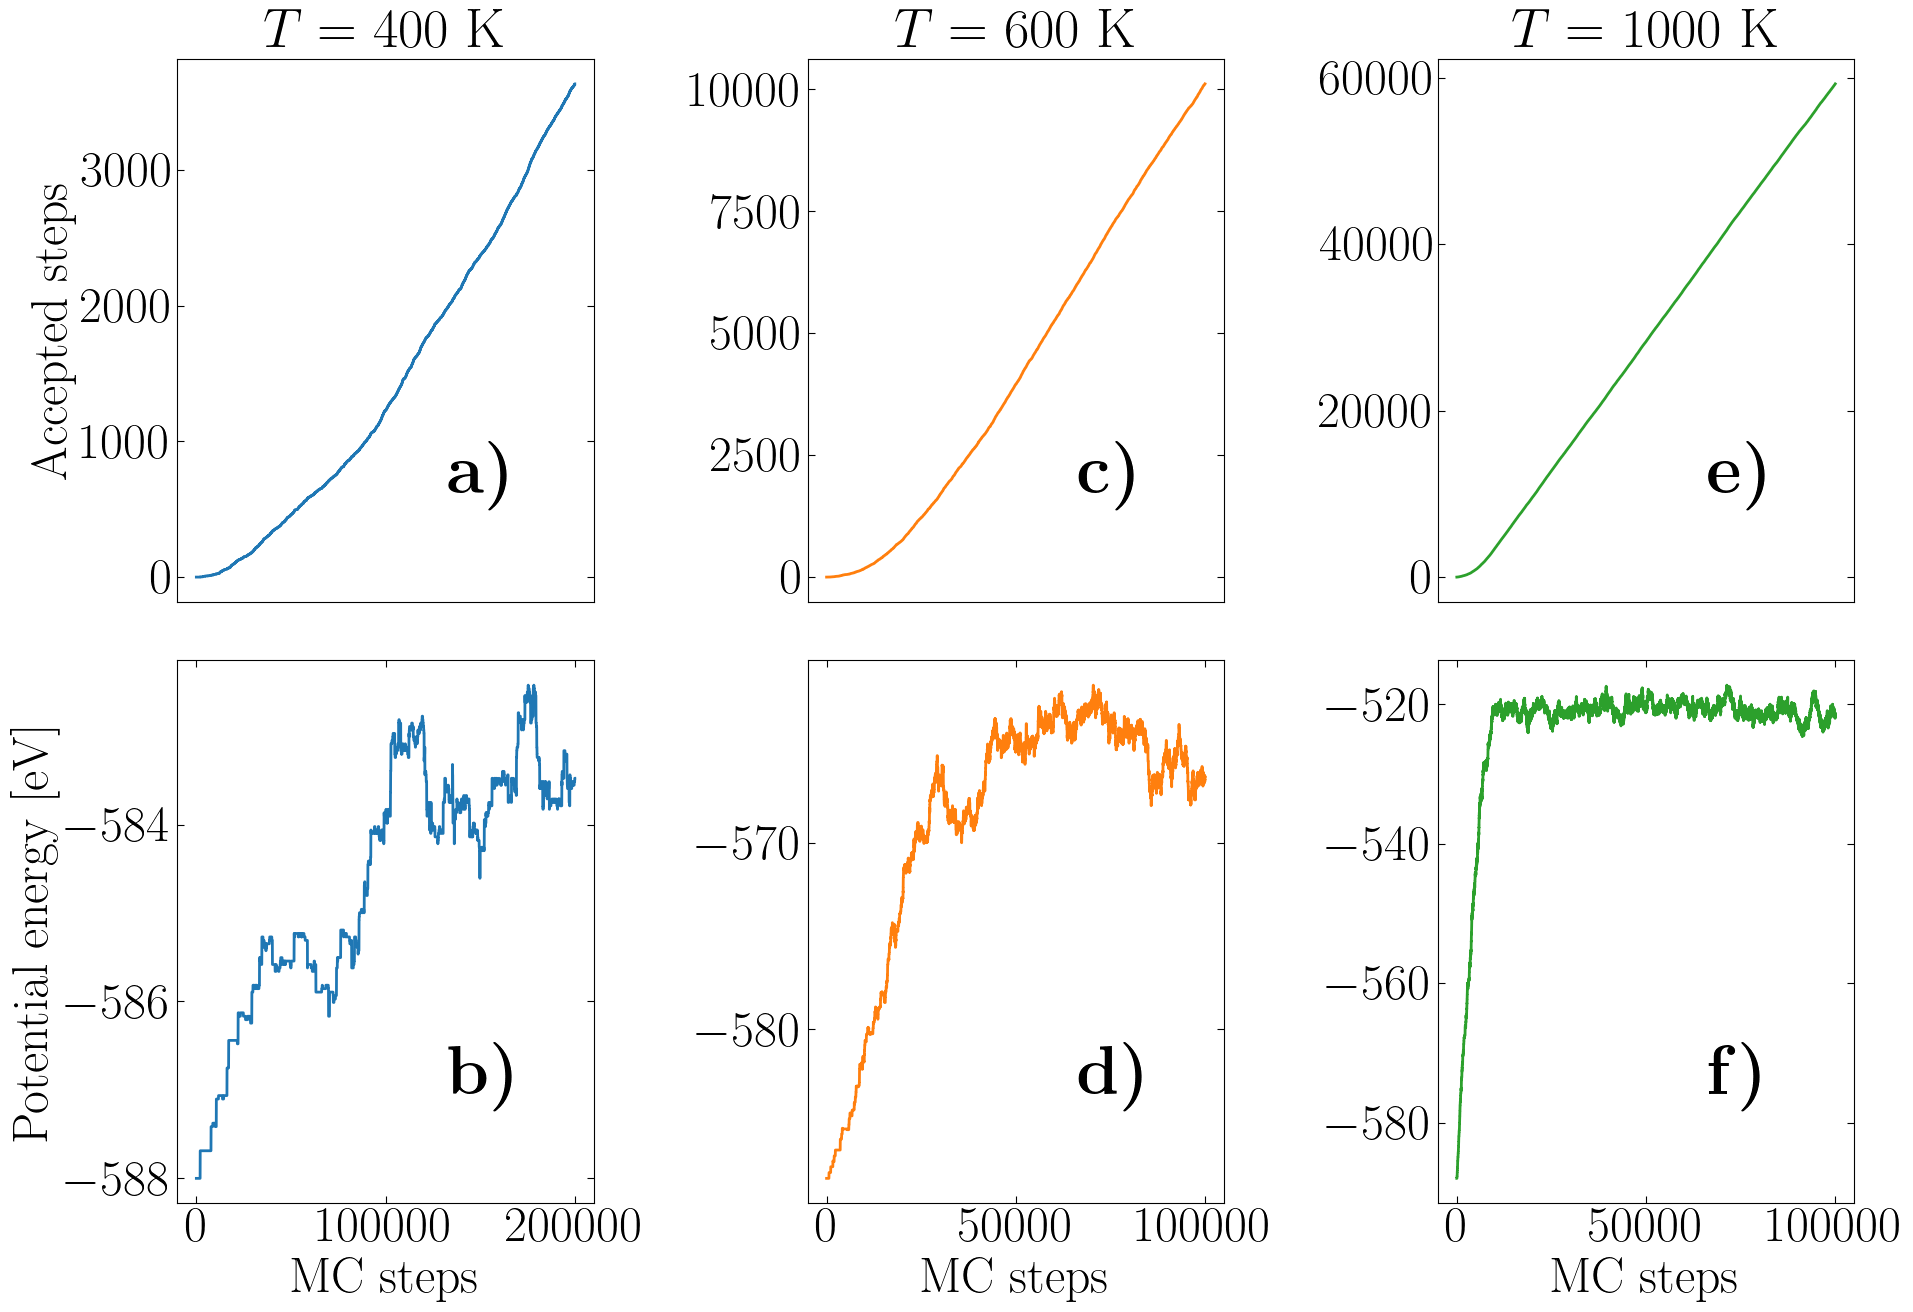

|   $T$ |   $E_{pot}$ |   $N_{eq}$ |   $\text{Acceptance}_{eq}$ |
|------:|------------:|-----------:|---------------------------:|
|   400 |    -583.761 |     200000 |                   0.018165 |
|   600 |    -562.973 |     100000 |                   0.10111  |
|  1000 |    -520.596 |     100000 |                   0.59238  |

In [77]:

its_eq_400 = 200000
its_eq = 100000
its = 1000000

# task_2_analyzer(400, its_eq_400, its, changed=True, plot=True, save=False)
analyzer_task_2([400, 600, 1000], [its_eq_400, its_eq, its_eq], its=None, changed=False, plot=True, save=True)

U_400, accept_400_eq = analyzer_task_2(400, its_eq_400, its, changed=False, plot=False, save=False)
U_600, accept_600_eq = analyzer_task_2(600, its_eq, its, changed=False, plot=False, save=False)
U_1000, accept_1000_eq = analyzer_task_2(1000, its_eq, its, changed=False, plot=False, save=False)

df = pd.DataFrame({'$T$': [400, 600, 1000], '$E_{pot}$': [np.mean(U_400), np.mean(U_600), np.mean(U_1000)], 
                   '$N_{eq}$': [its_eq_400, its_eq, its_eq], '$\\text{Acceptance}_{eq}$': [accept_400_eq, accept_600_eq, accept_1000_eq]})
markdown = df.to_markdown(index=False)
display(Markdown(markdown))


### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

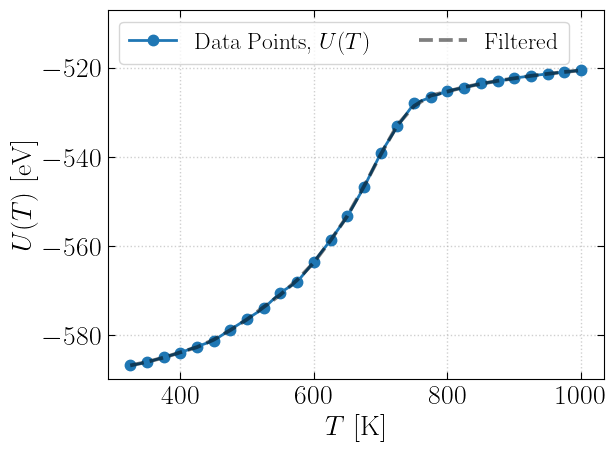

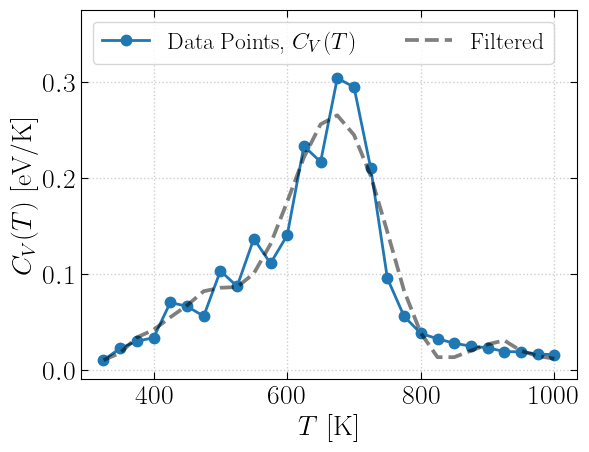

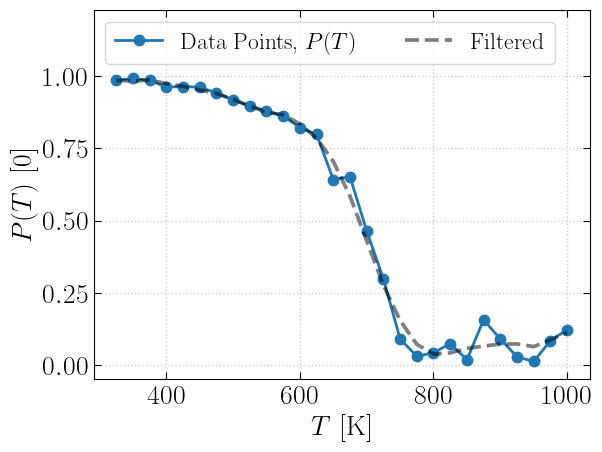

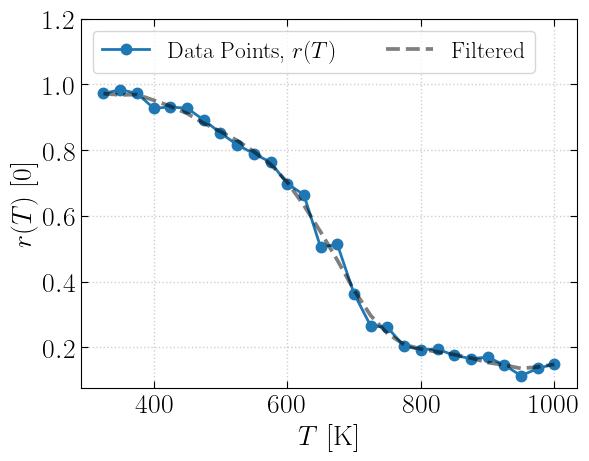

In [49]:

save = False
plot_task_3('U', save)
plot_task_3('C_V', save)
plot_task_3('P', save)
plot_task_3('r', save)

#### b) Error estimation using block average and autocorrelation

In [70]:

Ts = [300, 400, 500, 600, 700, 800, 900, 1000, '$\\textbf{{Mean}}$']
errors = {
    'U': [],
    'C_V': [],
    'P': [],
    'r': []
}
for T in Ts[:-1]:
    N, autocorr, block, error_dict = read_data(3, T)
    s_U, var_U = error_dict['U']
    s_CV, var_CV = error_dict['C_V']
    s_P, var_P = error_dict['P']
    s_r, var_r = error_dict['r']

    error_U = np.sqrt(s_U * var_U / N)
    error_CV = np.sqrt(s_CV * var_CV / N)
    error_P = np.sqrt(s_P * var_P / N)
    error_r = np.sqrt(s_r * var_r / N)

    errors['U'].append(error_U)
    errors['C_V'].append(error_CV)
    errors['P'].append(error_P)
    errors['r'].append(error_r)

errors['U'].append(f'$\\textbf{{{np.mean(errors["U"]):.2e}}}$')
errors['C_V'].append(f'$\\textbf{{{np.mean(errors["C_V"]):.2e}}}$')
errors['P'].append(f'$\\textbf{{{np.mean(errors["P"]):.2e}}}$')
errors['r'].append(f'$\\textbf{{{np.mean(errors["r"]):.2e}}}$')
df = pd.DataFrame({'$T$': Ts, '$\\epsilon\\hspace{0.1cm}(U)$': errors['U'], '$\\epsilon\\hspace{0.1cm}(C_V)$': errors['C_V'], '$\\epsilon\\hspace{0.1cm}(P)$': errors['P'], '$\\epsilon\\hspace{0.1cm}(r)$': errors['r']})
md_table = df.to_markdown(index=False)
display(Markdown(md_table))

# plt.figure()
# plt.plot(autocorr[:, 0], autocorr[:, 1], 'tab:blue')
# plt.plot(autocorr[:, 0], autocorr[:, 2], 'tab:orange')
# plt.plot(autocorr[:, 0], autocorr[:, 3], 'tab:green')
# plt.plot(autocorr[:, 0], autocorr[:, 4], 'tab:red')
# plt.axhline(np.exp(-2), color='k')

# plt.figure()
# plt.plot(block[:, 0], block[:, 1], 'tab:blue')
# plt.plot(block[:, 0], block[:, 2], 'tab:orange')
# plt.plot(block[:, 0], block[:, 3], 'tab:green')
# plt.plot(block[:, 0], block[:, 4], 'tab:red')

# plt.tight_layout()
# plt.show()


| $T$               | $\epsilon\hspace{0.1cm}(U)$   | $\epsilon\hspace{0.1cm}(C_V)$   | $\epsilon\hspace{0.1cm}(P)$   | $\epsilon\hspace{0.1cm}(r)$   |
|:------------------|:------------------------------|:--------------------------------|:------------------------------|:------------------------------|
| 300               | 0.06813900051245673           | 0.0009435956992421432           | 0.00043069054136648524        | 0.0008613810827329705         |
| 400               | 0.2934849292449808            | 0.007961262854880692            | 0.0020004397054026964         | 0.0037536262150796237         |
| 500               | 0.2710406536685847            | 0.006605598344655866            | 0.0020945355228964295         | 0.003473641286958653          |
| 600               | 0.27173382115236455           | 0.012205986745413813            | 0.0026891745694983776         | 0.0034831944677232497         |
| 700               | 0.8180485998663561            | 0.012770464162039445            | 0.022839290708488464          | 0.01048714464744551           |
| 800               | 0.12313601528354802           | 0.002143117191424857            | 0.01711147131420637           | 0.001579134584546903          |
| 900               | 0.06521296743777125           | 0.0007381396245522983           | 0.0069703370828158645         | 0.0008358425867520042         |
| 1000              | 0.05188920186360756           | 9.970126336058276e-05           | 0.0038332635725500915         | 0.0006647286897390854         |
| $\textbf{{Mean}}$ | $\textbf{2.45e-01}$           | $\textbf{5.43e-03}$             | $\textbf{7.25e-03}$           | $\textbf{3.14e-03}$           |